In [113]:
!pip install scikit-learn umap-learn fuzzy-c-means pandas numpy matplotlib seaborn ipywidgets -q

In [114]:
# Importing plotting libraries
import matplotlib.pyplot as plt  # For creating static, interactive, and animated visualizations
import seaborn as sns            # For making statistical graphics and visualization

# Importing dimensionality reduction and clustering libraries
import umap                      # For Uniform Manifold Approximation and Projection (UMAP)
import pandas as pd              # For data manipulation and analysis
import numpy as np               # For numerical operations on arrays
from fcmeans import FCM          # For Fuzzy Clustering and membership functions

# Importing preprocessing and evaluation metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler  # For feature scaling
from sklearn.metrics import silhouette_score, davies_bouldin_score               # For clustering evaluation metrics
from sklearn.model_selection import ParameterGrid                                # For generating parameter combinations

# Importing dimensionality reduction techniques
from sklearn.decomposition import PCA, TruncatedSVD  # For Principal Component Analysis and Singular Value Decomposition

# Importing clustering algorithms
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering, MeanShift  # For various clustering methods

# Importing manifold learning techniques
from sklearn.manifold import TSNE  # For t-Distributed Stochastic Neighbor Embedding (t-SNE) for dimensionality reduction

# Importing a utility for creating synthetic data
from sklearn.datasets import make_blobs  # For generating synthetic datasets with blob structure

In [115]:
class ClusteringModel:
    def __init__(self, raw_tensor, verbose=False, exclude_dict=None):
        """
        Initialize the ClusteringModel with raw data, optional verbosity, and exclusions.

        Parameters:
        - raw_tensor: The raw data tensor to be used for clustering.
        - verbose: If True, prints additional information during initialization.
        - exclude_dict: A dictionary specifying which scalers, reducers, or models to exclude.
        """
        self.raw_tensor = raw_tensor
        self.exclude_dict = exclude_dict if exclude_dict else {}

        self.scalers = {
            'MinMaxScaler': MinMaxScaler(),
            'StandardScaler': StandardScaler(),
            'RobustScaler': RobustScaler()
        }
        self.reducers = {
            'PCA': PCA,
            'UMAP': umap.UMAP,
            'SVD': TruncatedSVD
        }
        self.raw_tensor_scaled = {name: scaler.fit_transform(raw_tensor) for name, scaler in self.scalers.items() if name not in self.exclude_dict.get('scalers', [])}
        self.reduced_tensor = {}
        self.models = {
            'DBSCAN': {
                'eps': [round(i * 0.1, 1) for i in range(2, 8)],
                'min_samples': list(range(16, 16 * 4, 16))
            },
            'KMeans': {'n_clusters': list(range(5, 8))},
            'AgglomerativeClustering': {'n_clusters': list(range(2, 8))},
            'MeanShift': {'bandwidth': [1, 2, 3, 4, 5]},
            'FuzzyCMeans': {
                            'n_clusters': list(range(2, 8)),
                            'm': list(range(2, 5))
            }
        }
        self.best_model = None
        self.best_combination = None
        self.best_scaler = None
        self.best_reducer = None
        self.seed = 42
        self.verbose_global = True

        if verbose:
            print("[Init]: Initializing the class ... ")


    def reduce_dimension(self, method='PCA', n_components=2, verbose=False):
        """
        Reduce the dimensionality of the raw tensor using the specified method.
        It is an optional method, for the user, not directly used.

        Parameters:
        - method: The dimensionality reduction method to use ('PCA', 'UMAP', 'SVD').
        - n_components: Number of components for the reduction.
        - verbose: If True, prints additional information during the reduction.

        Returns:
        - A dictionary with the reduced tensors for each scaler.
        """
        if verbose:
            print(f"[Dimensionality Reduction]: Reducing dimensions using {method} ... ")
        
        if method not in self.reducers or method in self.exclude_dict.get('reducers', []):
            raise ValueError(f"Unsupported or excluded dimensionality reduction method: {method}")
        
        reducer_cls = self.reducers[method]
        kwargs = {'n_components': n_components}
            
        reducer = reducer_cls(**kwargs)
        
        self.reduced_tensor = {scaler_name: reducer.fit_transform(scaled_data) 
                            for scaler_name, scaled_data in self.raw_tensor_scaled.items()}
        return self.reduced_tensor


    def fit_models(self, use_reduction=True, use_scalers=True, verbose=False, n_dim=2):
        """
        Fit various clustering models to the data using optional scaling and dimensionality reduction.

        Parameters:
        - use_reduction: If True, apply dimensionality reduction before fitting models.
        - use_scalers: If True, apply scaling before fitting models.
        - verbose: If True, prints additional information during the model fitting.

        Returns:
        - A list of dictionaries containing evaluation metrics for each model configuration.
        """
        import warnings
        warnings.filterwarnings("ignore", message="n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.")

        results = []

        scalers_to_use = [(name, scaler) for name, scaler in self.scalers.items() if name not in self.exclude_dict.get('scalers', [])] if use_scalers else [('None', self.raw_tensor)]
        reducers_to_use = [(name, cls) for name, cls in self.reducers.items() if name not in self.exclude_dict.get('reducers', [])] if use_reduction else [('None', None)]

        for scaler_name, scaler in scalers_to_use:
            if scaler_name != 'None':
                scaled_data = scaler.fit_transform(self.raw_tensor)
                tensor_to_use = self.reduced_tensor.get(scaler_name, scaled_data) if use_reduction else scaled_data
            else:
                tensor_to_use = self.reduced_tensor.get(scaler_name, self.raw_tensor) if use_reduction else self.raw_tensor

            for reducer_name, reducer_cls in reducers_to_use:
                if reducer_name != 'None' and use_reduction:
                    kwargs = {'n_components': n_dim}
                    
                    # Handle random_state if applicable
                    if reducer_name in ["UMAP", "PCA", "SVD"]:
                        kwargs['random_state'] = self.seed
                        
                    reducer = reducer_cls(**kwargs)
                    tensor_to_use = reducer.fit_transform(tensor_to_use)
                
                for model_name, parameters in self.models.items():
                    if model_name in self.exclude_dict.get('models', []):
                        continue
                    
                    grid = self.generate_combinations(parameters)
                    
                    if verbose:
                        print(f"[ParamGrid]: Estimating the models for {model_name} with {scaler_name} and reducer {reducer_name} ... ")

                    for combination in grid:
                        if model_name == 'FuzzyCMeans':
                            model = self._create_model(model_name, combination)
                            model.fit(tensor_to_use)
                            labels = model.predict(tensor_to_use)
                        else:
                            model = self._create_model(model_name, combination)
                            labels = model.fit_predict(tensor_to_use)

                        n_labels = len(np.unique(labels))

                        if n_labels > 1:
                            silhouette = silhouette_score(tensor_to_use, labels)
                            db_index = davies_bouldin_score(tensor_to_use, labels)
                        else:
                            silhouette = -1
                            db_index = np.nan

                        results.append({
                            'scaler': scaler_name,
                            'reducer': reducer_name,
                            'model': model_name,
                            'combination': combination,
                            'silhouette_score': silhouette,
                            'davies_bouldin_score': db_index,
                            'groups': n_labels
                        })

                if verbose:
                    print(f"[Evaluation]: All the models with scalers and reducers were evaluated for {model_name} ... ")
                    print(f"-"*30)

        return results


    @staticmethod
    def generate_combinations(parameters):
        """
        Generate all possible combinations of parameters for grid search.

        Parameters:
        - parameters: A dictionary of parameter names and their possible values.

        Returns:
        - An iterator over the combinations of parameters.
        """
        return ParameterGrid(parameters)

    def _create_model(self, model_name, combination):
        """
        Create a clustering model instance based on the specified model name and parameters.

        Parameters:
        - model_name: The name of the model to create ('DBSCAN', 'KMeans', 'AgglomerativeClustering', 'MeanShift', 'FuzzyCMeans').
        - combination: A dictionary of parameters for the model.

        Returns:
        - An instance of the specified clustering model.

        Raises:
        - ValueError if the model name is unsupported.
        """
        if model_name == 'DBSCAN':
            return DBSCAN(eps=combination['eps'], min_samples=combination['min_samples'])
        elif model_name == 'KMeans':
            return KMeans(n_clusters=combination['n_clusters'], random_state=self.seed)
        elif model_name == 'AgglomerativeClustering':
            return AgglomerativeClustering(n_clusters=combination['n_clusters'])
        elif model_name == 'MeanShift':
            return MeanShift(bandwidth=combination['bandwidth'])
        elif model_name == 'FuzzyCMeans':
            return FCM(n_clusters=combination['n_clusters'], m = combination['m'], random_state=self.seed)
        else:
            raise ValueError(f"Unsupported model: {model_name}")

    def select_best_model(self, metric='silhouette', use_reduction=True, use_scalers=True, n_min=2, n_max=8, verbose=False):
        """
        Select the best clustering model based on evaluation metrics and specified criteria.

        Parameters:
        - metric: The metric to use for selecting the best model ('silhouette' or 'davies_bouldin').
        - use_reduction: If True, consider dimensionality reduction.
        - use_scalers: If True, consider scaling.
        - n_min: Minimum number of clusters to consider.
        - n_max: Maximum number of clusters to consider.
        - verbose: If True, prints additional information during model selection.

        Returns:
        - A dictionary with the best model, parameters, scaler, and reducer.
        - A DataFrame with the filtered results.
        """
        results = self.fit_models(use_reduction=use_reduction, use_scalers=use_scalers, verbose=verbose)
        df_results = pd.DataFrame(results)

        df_filtered = df_results[
            (df_results['groups'].between(n_min, n_max)) &
            (df_results['silhouette_score'] > 0)
        ].reset_index(drop=True)

        if df_filtered.empty:
            raise ValueError("[WARNING]: No valid models found with the given criteria.")

        if metric == 'silhouette':
            df_sorted = df_filtered.sort_values(by='silhouette_score', ascending=False)
        elif metric == 'davies_bouldin':
            df_sorted = df_filtered.sort_values(by='davies_bouldin_score', ascending=True)
        else:
            raise ValueError(f"Unsupported metric: {metric}")
        
        df_sorted = df_sorted.reset_index(drop = True)
        
        best_model_row = df_sorted.iloc[0]

        self.best_model = best_model_row['model']
        self.best_combination = best_model_row['combination']
        self.best_scaler = best_model_row['scaler']
        self.best_reducer = best_model_row['reducer']
        
        if verbose:
            print("[Selection]: Best model was selected ... ")
            
        return {
            'best_model': self.best_model,
            'best_parameters': self.best_combination,
            'scaler': self.best_scaler,
            'reducer': self.best_reducer
        }, df_sorted
        
    def manual_selection_model(self, df_sorted, n_index):
        """
        Select manually a model based on the metric results.

        Parameters:
        - df_sorted: The pd.DataFrame with the models results.
        - n_index: Integer with the index of the desired model.

        Returns:
        - A dictionary with the best model, parameters, scaler, and reducer.
        """
        
        best_model_row = df_sorted.iloc[n_index]
        
        best_model = best_model_row['model']
        best_combination = best_model_row['combination']
        best_scaler = best_model_row['scaler']
        best_reducer = best_model_row['reducer']
        
        return {
            'best_model': best_model,
            'best_parameters': best_combination,
            'scaler': best_scaler,
            'reducer': best_reducer
        }

    def estimate_best_model(self, best_params=None, use_reduction=True, use_scalers=True, verbose=False):
        """
        Estimate the cluster labels using the best selected model.

        Parameters:
        - use_reduction: If True, apply dimensionality reduction using the best reducer.
        - use_scalers: If True, apply scaling using the best scaler.
        - verbose: If True, prints additional information during label estimation.

        Returns:
        - An array of cluster labels for each data point.

        Raises:
        - ValueError if no best model has been selected.
        """
        if best_params != None:
            try:
                self.best_model = best_params['best_model']
                self.best_combination = best_params['best_parameters']
                if best_params['scaler']:
                    self.best_scaler = best_params['scaler']
                if best_params['reducer']:
                    self.best_reducer = best_params['reducer']
            except:
               raise ValueError("[ERROR]: Model introduced was not valid.") 

        if verbose:
            print("[Best Model]: Best model params updated ... ")
            
        if self.best_model is None or self.best_combination is None:
            raise ValueError("[ERROR]: No best model selected. Run select_best_model first.")
        
        if not use_reduction or self.best_reducer == 'None':
            tensor_to_use = self.raw_tensor
        else:
            tensor_to_use = self.reduced_tensor.get(self.best_scaler, self.raw_tensor_scaled.get(self.best_scaler, self.raw_tensor))
        
        if use_scalers and self.best_scaler != 'None':
            tensor_to_use = self.raw_tensor_scaled.get(self.best_scaler, self.raw_tensor)

        model = self._create_model(self.best_model, self.best_combination)

        if self.best_model == 'FuzzyCMeans':
            model = self._create_model(self.best_model, self.best_combination)
            model.fit(tensor_to_use)
            labels = model.predict(tensor_to_use)
        else:
            labels = model.fit_predict(tensor_to_use)
        if verbose:
            print("[Best Model]: Best model label estimated ... ")
            
        return labels
    
    def fit_tsne(self, n_components=2, perplexity=30, learning_rate=200, verbose=False):
        """
        Fit t-SNE on the data using the best model and obtain 2D embeddings.

        Parameters:
        - n_components: Number of dimensions for t-SNE.
        - perplexity: Perplexity parameter for t-SNE.
        - learning_rate: Learning rate parameter for t-SNE.

        Raises:
        - ValueError if the best model has not been selected yet.
        """
        if self.best_model is None or self.best_combination is None:
            raise ValueError("[WARNING]: Best model has not been selected yet. Please run select_best_model first.")
        
        if self.best_reducer == 'None':
            tensor_to_use = self.raw_tensor
        else:
            tensor_to_use = self.reduced_tensor.get(self.best_scaler, self.raw_tensor_scaled.get(self.best_scaler, self.raw_tensor))

        
        tsne = TSNE(n_components=n_components, perplexity=perplexity, learning_rate=learning_rate, random_state=self.seed)
        self.tsne_results = tsne.fit_transform(tensor_to_use)
        
        if verbose:
            print("[t-SNE]: Dimension reduction into 2D was completed.")

    def plot_tsne(self, labels):
        """
        Plot the t-SNE results to visualize the clustering results in 2D.

        Raises:
        - ValueError if t-SNE results or labels are not available. Please run fit_tsne first.
        """
        if self.tsne_results is None or labels is None:
            raise ValueError("[WARNING]: t-SNE results or labels are not available. Please run fit_tsne first.")
        
        tsne_df = pd.DataFrame(self.tsne_results, columns=['Dimension 1', 'Dimension 2'])
        tsne_df['Cluster'] = labels
        
        plt.figure(figsize=(6, 4))
        sns.scatterplot(
            x='Dimension 1', y='Dimension 2', hue='Cluster', palette='tab10',
            data=tsne_df, legend='full', alpha=0.7
        )
        plt.title('t-SNE Visualization of Clustering Results')
        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')
        plt.legend(title='Cluster')
        plt.show()

In [116]:
# Set a random seed for reproducibility
SEED = 42

# Generate a sample dataset with blobs
X, _ = make_blobs(n_samples=1000, centers=5, cluster_std=0.4)

# Exclusion Dict (Optional)
exclude_dict = {
    'scalers': ['StandardScaler'],
    'reducers': ['UMAP'],
    'models': ['KMeans']
}

clustering_model = ClusteringModel(X, exclude_dict=exclude_dict)

In [117]:
# Select the best model based on the silhouette score
best_model_params, df_models_sorted = clustering_model.select_best_model()

In [118]:
# Print the models results
df_models_sorted

,scaler,reducer,model,combination,silhouette_score,davies_bouldin_score,groups
0,RobustScaler,PCA,DBSCAN,"{'eps': 0.2, 'min_samples': 16}",0.874830,0.174188,5
1,RobustScaler,SVD,DBSCAN,"{'eps': 0.2, 'min_samples': 16}",0.874830,0.174188,5
2,RobustScaler,PCA,DBSCAN,"{'eps': 0.2, 'min_samples': 48}",0.874830,0.174188,5
3,RobustScaler,SVD,FuzzyCMeans,"{'m': 4, 'n_clusters': 5}",0.874830,0.174188,5
4,RobustScaler,SVD,DBSCAN,"{'eps': 0.2, 'min_samples': 48}",0.874830,0.174188,5
...,...,...,...,...,...,...,...
153,RobustScaler,PCA,FuzzyCMeans,"{'m': 2, 'n_clusters': 2}",0.613649,0.398691,2
154,RobustScaler,SVD,FuzzyCMeans,"{'m': 3, 'n_clusters': 2}",0.603576,0.423024,2
155,RobustScaler,PCA,FuzzyCMeans,"{'m': 3, 'n_clusters': 2}",0.603576,0.423024,2
156,RobustScaler,PCA,FuzzyCMeans,"{'m': 4, 'n_clusters': 2}",0.601592,0.428348,2


In [119]:
# Print the best model parameters
best_model_params

{'best_model': 'DBSCAN',
 'best_parameters': {'eps': 0.2, 'min_samples': 16},
 'scaler': 'RobustScaler',
 'reducer': 'PCA'}

In [120]:
# Select manually a model (Optional)
clustering_model.manual_selection_model(df_models_sorted, 3)

{'best_model': 'FuzzyCMeans',
 'best_parameters': {'m': 4, 'n_clusters': 5},
 'scaler': 'RobustScaler',
 'reducer': 'SVD'}

In [121]:
# Estimate the labels using the best model
labels = clustering_model.estimate_best_model(best_params = best_model_params)

In [122]:
# Initialize t-SNE for dimensionality reduction
clustering_model.fit_tsne()

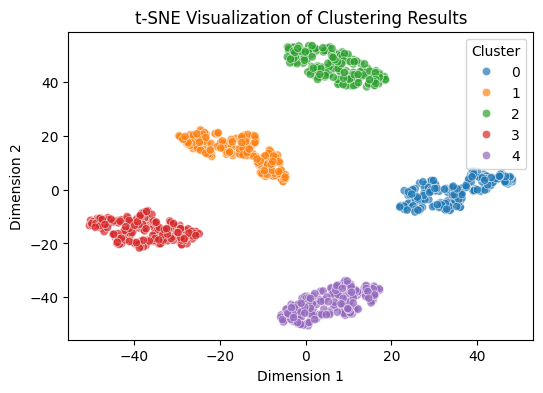

In [123]:
# Plot the t-SNE results
clustering_model.plot_tsne(labels)